Name : Masyithah binti Mohd Farid

Matric number : 17204447

### NutriAI Advisor - developed with combination of Gpt-3.5-turbo and Stable diffusion model. It offers users personalized recommendations and advice on dietary and nutritional matters.

AI Nutritionist takes information from the users as inputs and generate recommendation of dietery needs based on that. In this code, you will see first few questions are already already pre-defined where the users just need to answer simple questions or yes-or-no questions. However, if the users what AI Nutritionist to provide specific recommendation for them, they could ask after they have completed the prepared questions. AI Nutritionist gives the users tips and recommendations for personalized body composition and fitness planning.





### AI Nutritionist - Overall flow and process
1. User is first required to input their information (gender, age, weight, height, goals).
2. The system will calculate the Body Mass Index(BMI) of that person.
3. The system will generate meal plans mainly breakfast, lunch, snack, dinner. The output of meal plan will be in form of dish name (generated by ChatGPT) and also a picture of the dish (generated by Stable Diffusion).
4. The users are asked with two question regarding their allergies and disease if they have and the system will store the input to be used later.
5. The following questions are already prepared, the users will just need to answer yes or no if they would like to know more details about each question.
6. If the answer of user is yes, there will be generated tips from ChatGPT and generated image from Stable Diffusion.
7. If the answer of user is no, it will proceed with the next question until the last prepared question being asked.
8. Lastly, user is freely to ask any specific question they would to know (anything about nutritional, dietery needs or fitness).
9. The output of those questions will also be in form of words generated by ChatGPT and picture generated by Stable Diffusion.
10. If users do not have any other question to ask, they can answer 'no', and the conversation will stop.

In [ ]:
!nvidia-smi

Fri Jun 23 13:58:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.7 

In [ ]:
# import dependencies
import torch
from diffusers import StableDiffusionPipeline
import random
import requests
from google.colab import files
import openai
import re

openai.api_key = "your api key"
URL = "https://api.openai.com/v1/chat/completions"

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
random.seed(100)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Functions
1. get_user_info : This function will prompt the user to input their information such as gender, age, height and goal (it can be lose weight or gain weight or build muscle or anything)
2. generate_meal_plans : This functions generate meal plans using Chat GPT based on the input given by user.
3. seperate_meals : This function takes the answer provided by Chat GPT about the suggested meal plans and extract value for each meal (breakfast, lunch, snack and dinner) and put the meal inside a new list.
4. generate_images_of_meal_plan : This function generates images, each for one meal, using Stable Diffusion, and display the images generated.
5. following questions : This function already prepared questions for user and prompts for Chat GPT to generate answers. The questions are all depend on the user if they would to know or not. The answers given by this system will be in form of words and images.
6. question_from_user : This function takes input from user if they have any other concern or question that they would to ask specifically. The output will also be in the same form.

In [ ]:
def get_user_info():
  gender = input("What is your gender? : ")
  age = int(input("What is your age? : "))
  weight = int(input("What is your weight?(kg) : "))
  height = int(input("What is your height?(cm) : "))
  goal = input("What is your goal that you want to achieve? : ")

  bmi = weight/((height/100)**2)

  return gender, age, bmi, goal


def generate_meal_plans():
  payload = {
    "model": "gpt-3.5-turbo",
    "temperature" : 1.0,
    "messages" : [
      {"role": "system", "content": "You are a nutritionist. You know everyting about diet, nutrition and healthy lifestyle. Answer the questions related to dietary habits and nutritional needs only"},
      {"role": "user", "content": f"Provide a meal plan of balanced diet for a people with {age}, gender {gender}, has bmi of {bmi} and want to {goal}. The meal plan should consist of 4 meals mainly breakfast, lunch, snack, dinner. Your provided answer should be in the format like this. 'Breakfast : Your suggestion in 1 sentence', 'Lunch : Your suggestion in 1 sentence', and so on."}
    ]
  }

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
  }

  response = requests.post(URL, headers=headers, json=payload)
  response = response.json()
  answer = response['choices'][0]['message']['content']
  meals = seperate_meals(answer)

  return meals


def seperate_meals(answer):
  values = []
  breakfast_match = re.search(r"Breakfast: (.+)", answer)
  if breakfast_match:
      values.append(breakfast_match.group(1))

  lunch_match = re.search(r"Lunch: (.+)", answer)
  if lunch_match:
      values.append(lunch_match.group(1))

  snack_match = re.search(r"Snack: (.+)", answer)
  if snack_match:
      values.append(snack_match.group(1))

  dinner_match = re.search(r"Dinner: (.+)", answer)
  if dinner_match:
      values.append(dinner_match.group(1))
  return values

def generate_images_of_meal_plan():
  images = []
  meal = ['Breakfast', 'Lunch', 'Snack', 'Dinner']
  print("Suggested meal plans for you:")

  for i in range(len(meals)):
    prompt = "Generate a clear and 4k image of "+ meals[i]
    image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

  # Now to display an image you can either save it such as:

    print(meal[i] + " : " + meals[i])
    image.show()



def following_questions():
  allergies = input('Do you have any food allergies? Please specify. : ')
  disease = input('Do you currently have any medical conditions or illnesses? : ')

  next_questions = ['Would you like me to create a meal plan that avoids those allergens?  \nAnswer : ',
                    '\n\nWould you like to know the dietary patterns or specific foods that can reduce the risk of your disease? \nAnswer (yes or no): ',
                    '\n\nWould you like to know what should you eat before and after your workouts to optimize performance and recovery?  \nAnswer (yes or no): ',
                    '\n\nWould you like to know if there is any specific supplements that I would recommend for general health and well-being?  \nAnswer (yes or no): ',
                    '\n\nWould you like to know what are some sustainable lifestyle changes you can make to maintain a healthy weight in the long term? : \nAnswer (yes or no): ']

  next_prompts = [f'Special Diets for {allergies} allergies',
                  f'Disease Prevention for {disease}',
                  'Sports Nutrition',
                  'Nutritional Supplement',
                  'Weight Management']

  for i in range(len(next_questions)):
    user_input = input(next_questions[i])
    if user_input == 'yes':
      payload = {
        "model": "gpt-3.5-turbo",
        "temperature" : 1.0,
        "messages" : [
          {"role": "system", "content": "You are a nutritionist. You know everyting about diet, nutrition and healthy lifestyle. Answer the questions related to dietary habits and nutritional needs only"},
          {"role": "user", "content": f"Provide {next_prompts[i]} for a people with {age}, gender {gender}, has bmi of {bmi} and want to {goal}. Your provided answer should be in 1 sentence only."}
        ]
      }
      headers = {
        "Content-Type": "application/json",
      "Authorization": f"Bearer {openai.api_key}"
      }
      response = requests.post(URL, headers=headers, json=payload)
      response = response.json()
      answer = response['choices'][0]['message']['content']

      prompt = "Generate a clear and 4k image of "+ answer
      image = pipe(prompt).images[0]

      print(answer)
      image.show()

    else:
      continue

def question_from_user():
  while True:
    yes_no = input('\n\nDo you have any other question you would like to ask on nutrition and dietary advice? (yes or no): ')

    if yes_no == 'yes':
      question = input('Please specify : ')


      payload = {
        "model": "gpt-3.5-turbo",
        "temperature" : 1.0,
        "messages" : [
          {"role": "system", "content": "You are a nutritionist. You know everyting about diet, nutrition and healthy lifestyle. Answer the questions related to dietary habits and nutritional needs only"},
          {"role": "user", "content": f"Provide {question} for a people with {age}, gender {gender}, has bmi of {bmi} and want to {goal}. Your provided answer should be in 1 sentence only."}
        ]
      }
      headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
      }
      response = requests.post(URL, headers=headers, json=payload)
      response = response.json()
      answer = response['choices'][0]['message']['content']

      prompt = "Generate a clear and 4k image of "+ answer
      image = pipe(prompt).images[0]

      print(answer)
      image.show()

    else:
      break


What is your gender? : female
What is your age? : 22
What is your weight?(kg) : 40
What is your height?(cm) : 160
What is your goal that you want to achieve? : gain weight
Suggested meal plans for you:


  0%|          | 0/50 [00:00<?, ?it/s]

Breakfast : Two slices of whole wheat toast with peanut butter, banana, and a glass of whole milk.


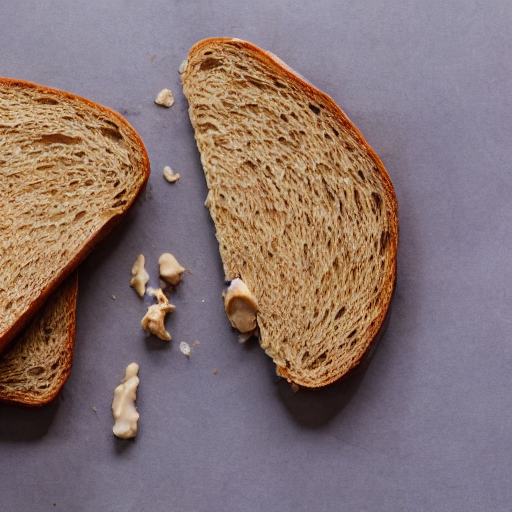

  0%|          | 0/50 [00:00<?, ?it/s]

Lunch : Grilled chicken breast with quinoa and roasted vegetables.


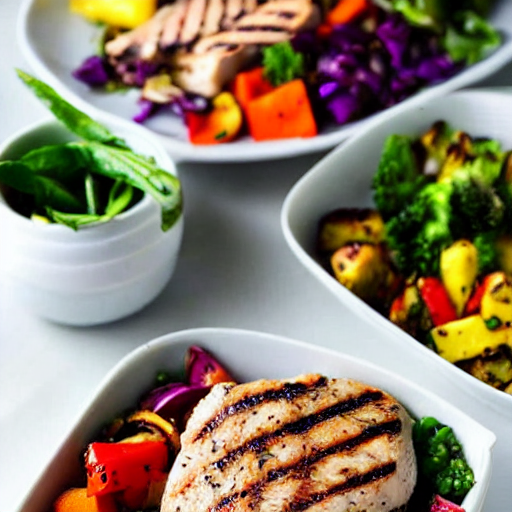

  0%|          | 0/50 [00:00<?, ?it/s]

Snack : Greek yogurt with mixed berries and granola.


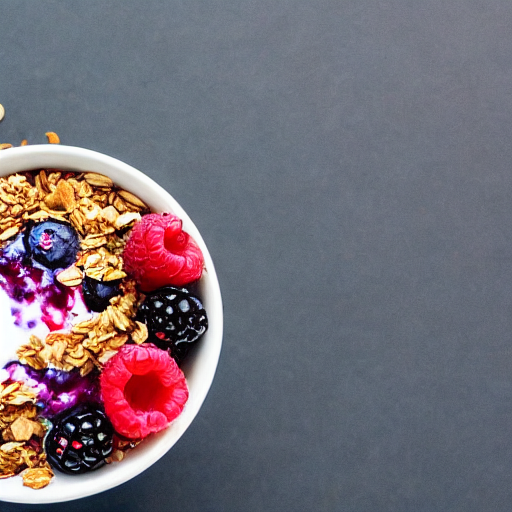

  0%|          | 0/50 [00:00<?, ?it/s]

Dinner : Baked salmon with sweet potato and mixed green salad with avocado dressing.


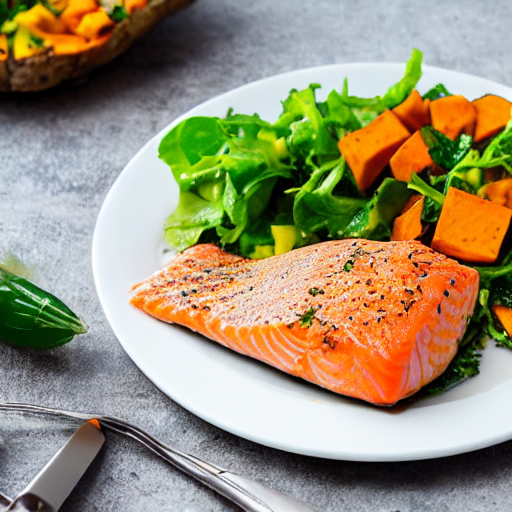

Do you have any food allergies? Please specify. : fish
Do you currently have any medical conditions or illnesses? : high blood pressure
Would you like me to create a meal plan that avoids those allergens?  
Answer : yes


  0%|          | 0/50 [00:00<?, ?it/s]

A fish allergy necessitates an elimination diet that excludes all fish products, and a nutritionally balanced high-calorie diet is ideal for weight gain.


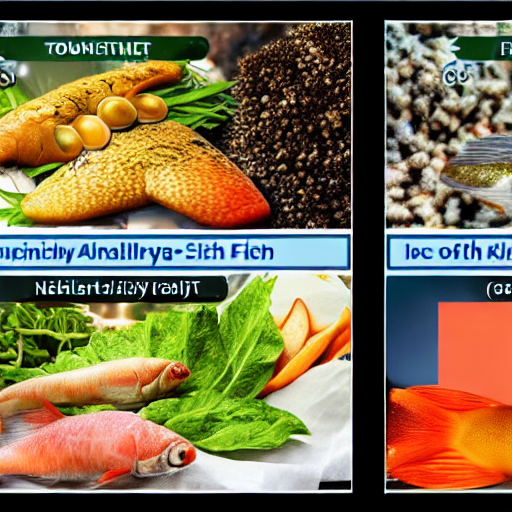



Would you like to know the dietary patterns or specific foods that can reduce the risk of your disease? 
Answer (yes or no): yes


  0%|          | 0/50 [00:00<?, ?it/s]

Increase caloric intake by consuming nutrient-dense, heart-healthy foods to achieve a healthy BMI and reduce the risk of developing high blood pressure.


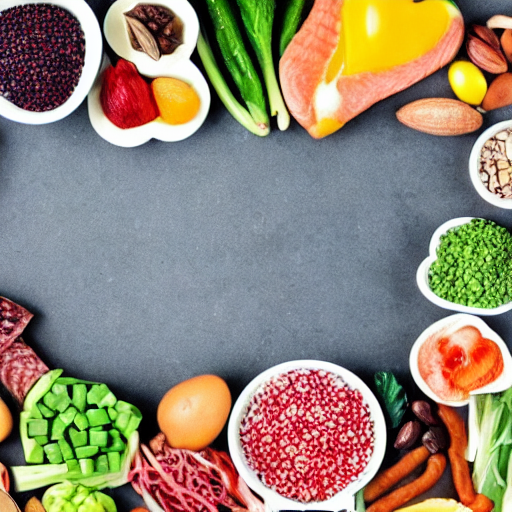



Would you like to know what should you eat before and after your workouts to optimize performance and recovery?  
Answer (yes or no): yes


  0%|          | 0/50 [00:00<?, ?it/s]

To gain weight, increase calorie intake through a balanced diet that includes lean proteins, healthy fats, complex carbohydrates, and nutrient-dense foods, complemented with a strength-training program.


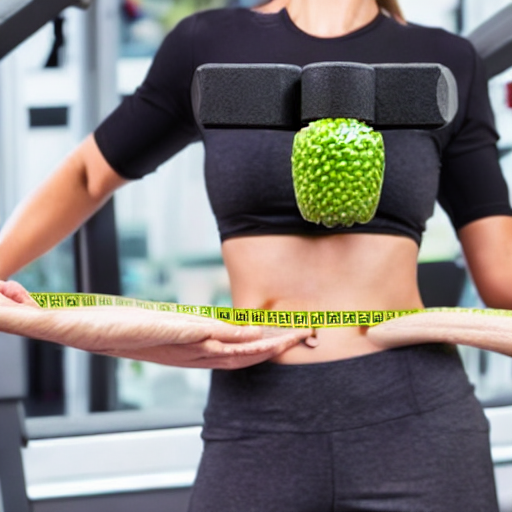



Would you like to know if there is any specific supplements that I would recommend for general health and well-being?  
Answer (yes or no): no


Would you like to know what are some sustainable lifestyle changes you can make to maintain a healthy weight in the long term? : 
Answer (yes or no): yes


  0%|          | 0/50 [00:00<?, ?it/s]

To gain weight, a 22-year-old female with a BMI of 15.62 should consume additional servings of nutrient-dense foods and increase overall calorie intake.


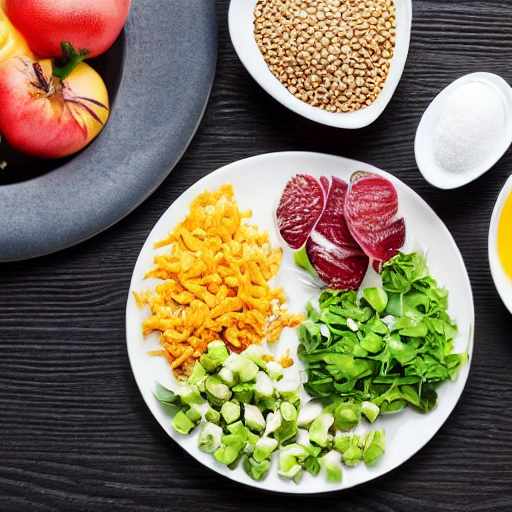



Do you have any other question you would like to ask on nutrition and dietary advice? (yes or no): yes
Please specify : any recommendation exercise for a busy student


  0%|          | 0/50 [00:00<?, ?it/s]

Weight training exercises are recommended to build muscle and gain weight.


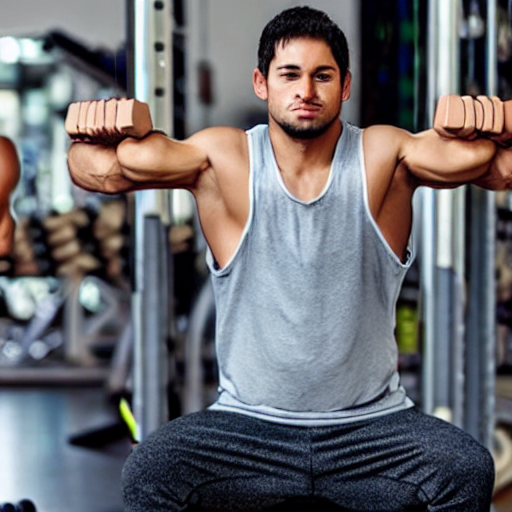



Do you have any other question you would like to ask on nutrition and dietary advice? (yes or no): no
That would be all. Live a healthy lifestyle. Thank you.


In [ ]:
gender = input("What is your gender? : ")
age = int(input("What is your age? : "))
weight = int(input("What is your weight?(kg) : "))
height = int(input("What is your height?(cm) : "))
goal = input("What is your goal that you want to achieve? : ")

bmi = weight/((height/100)**2)

meals = generate_meal_plans()

generate_images_of_meal_plan()

following_questions()

question_from_user()

print("That would be all. Live a healthy lifestyle. Thank you.")